In [33]:
import torch
import torch.nn as nn
import numpy as np
import os
import time
import copy

# Generate synthetic dataset
random_state = 42
np.random.seed(random_state)
X = np.random.rand(100, 10) # 100 datapoints of 10 features each
y = np.random.randint(0, 2, size = 100) # binary classification labels

# Initialize arrays for storing weights
initial_weights = []
final_weights = []
diff_weights = []


class DynamicDataset(Dataset):
    def __init__(self, data):
        # X: (N, 9), Y: (N, 6)
        self.X = data['X'].astype(np.float32)
        self.Y = data['Y'].astype(np.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

#define model
class NeuralNet(nn.Module):
    # ---
    # Your code goes here
    def __init__(self, input_dim, units):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, units)
        self.layer2 = nn.Linear(units, 1)

    def forward(self, x):
        x = nn.functional.relu(self.layer1(x))
        x = torch.sigmoid(self.layer2(x))
        return x

def train(model, train_loader):
    model.train()
    train_loss = 0.0

    for i, (features, labels) in enumerate(train_loader):
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        train_prediction = model.forward(features)
        labels = labels.view(-1, 1)
        # print(
        #     f"prediction: {train_prediction}, and its shape: {train_prediction.size()}")
        # print(f"ground_truth: {labels}, and its shape: {labels.size()}")
        loss = criterion(train_prediction, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    # print(f"train loss: {train_loss/(i+1)}")
    # ---
    return train_loss

def test(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
      for i, data in enumerate(test_loader):
          features = data[0]
          labels = data[1]
          test_prediction = model.forward(features)
          loss = criterion(test_prediction, labels)
          test_loss += loss.item()
    print(f"test loss: {test_loss/(i+1)}\n")
    # ---
    return test_loss

# We are only using CPU, and GPU is not allowed.
device = torch.device("cpu")
# torch.manual_seed(random_state)

data = {"X":X, "Y":y}
dataset = DynamicDataset(data)
batch_size = 1
train_loader = torch.utils.data.DataLoader(
    dataset, shuffle=True, batch_size=batch_size)
# The name of the directory to save all the checkpoints
timestr = time.strftime("%Y-%m-%d_%H-%M-%S")
model_dir = os.path.join('models', timestr)

# Define the range of units in the first layer
unit_range = np.arange(100, 1050, 10)

for units in unit_range:
    # Define the model architecture
    print(f"Number of units: {units}")
    model = NeuralNet(input_dim=10, units=units)
    model = model.to(device)
    
    # Print initial weights
    # initial_weights.append(model.layers[0].get_weights()[0])
    # initial_model_copy = type(model)(input_dim=10, units=units)
    # initial_model_copy.load_state_dict(model.state_dict())
    # initial_layer_weights = initial_model_copy.state_dict()
    initial_layer_weights = copy.deepcopy(model.state_dict())  # to keep it seperate from its internal pointers
    initial_weights.append(initial_layer_weights)
    # print(f"initial layer weights: \n{initial_layer_weights}")
    # Compile the model with a loss function and an optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=.001)
    criterion = nn.BCELoss()

    epochs = 100
    previous_lowest_train_loss = float('inf')
    for epoch in range(1, 1 + epochs):
        # print(f"epoch number {epoch}")
        train_loss = train(model=model, train_loader=train_loader)
        # test_loss = test(model=model)
        # if previous_lowest_train_loss > train_loss:
        #     previous_lowest_test_loss = test_loss
        #     model_folder_name = f'epoch_{epoch:04d}_loss_{train_loss:.8f}'
        #     if not os.path.exists(os.path.join(model_dir, model_folder_name)):
        #         os.makedirs(os.path.join(model_dir, model_folder_name))
        #     torch.save(model.state_dict(), os.path.join(
        #         model_dir, model_folder_name, 'model.pth'))
    final_layer_weights = model.state_dict()
    final_weights.append(final_layer_weights)
    # print(f"final layer weights: \n{final_layer_weights}")
    layer1_max_difference = torch.max(final_weights[-1]["layer1.weight"] - initial_weights[-1]["layer1.weight"])
    layer2_max_difference = torch.max(final_weights[-1]["layer2.weight"] - initial_weights[-1]["layer2.weight"])
    print(f"layer 1 diff: {layer1_max_difference}")
    print(f"layer 2 diff: {layer2_max_difference}")
    max_difference = max(layer1_max_difference, layer2_max_difference)
    print(f"the max difference is {max_difference} for {units} units\n")
    diff_weights.append(max_difference)


Number of units: 100
layer 1 diff: 0.6822420358657837
layer 2 diff: 1.9136732816696167
the max difference is 1.9136732816696167 for 100 units

Number of units: 110
layer 1 diff: 0.7225227355957031
layer 2 diff: 1.8921277523040771
the max difference is 1.8921277523040771 for 110 units

Number of units: 120
layer 1 diff: 0.5606672763824463
layer 2 diff: 1.511739730834961
the max difference is 1.511739730834961 for 120 units

Number of units: 130
layer 1 diff: 0.543113112449646
layer 2 diff: 1.8627523183822632
the max difference is 1.8627523183822632 for 130 units

Number of units: 140
layer 1 diff: 0.5745408535003662
layer 2 diff: 1.7248177528381348
the max difference is 1.7248177528381348 for 140 units

Number of units: 150
layer 1 diff: 0.5602594614028931
layer 2 diff: 1.6180408000946045
the max difference is 1.6180408000946045 for 150 units

Number of units: 160
layer 1 diff: 0.6071875095367432
layer 2 diff: 1.615868091583252
the max difference is 1.615868091583252 for 160 units

Numb

In [34]:
import pickle
pickle.dump(diff_weights, open( "data.pkl", "wb" ) )

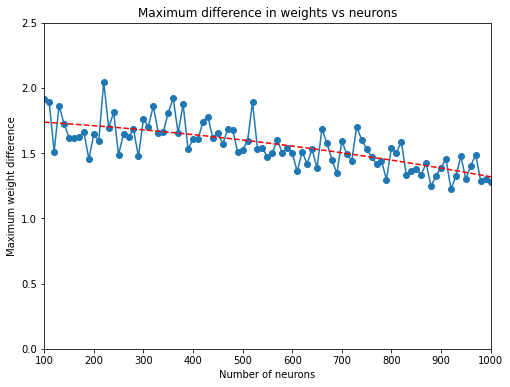

In [36]:
import matplotlib.pyplot as plt

max_vals = []

for i in range(len(diff_weights)):
    max_vals.append(diff_weights[i])
    
# set the size of the figure
fig, ax = plt.subplots(figsize = (8, 6))

# create the plot
ax.plot(unit_range, max_vals, linestyle = '-', marker = 'o')

# set the title and axis labels
ax.set_title('Maximum difference in weights vs neurons')
ax.set_xlabel('Number of neurons')
ax.set_ylabel('Maximum weight difference')
ax.set_ylim([0, 2.5])
ax.set_xlim([100, 1000])

# calculate line of best fit
coefficients = np.polyfit(unit_range, max_vals, 2)
line_of_best_fit = coefficients[0] * unit_range**2 + coefficients[1] * unit_range + coefficients[2]

# plot line of best fit 
ax.plot(unit_range, line_of_best_fit, linestyle = '--', color = 'red')

# display the plot
plt.show()